reproduction: <br>
Jon S. McElvain, Walter Gish, "Camera Color Correction Using Two-Dimensional Transforms"  in Proc. IS&T 21st Color and Imaging Conf.,  2013,  pp 250 - 256,  https://doi.org/10.2352/CIC.2013.21.1.art00046 <br>

<br>
DataSet biolink<br>
https://www2.cs.sfu.ca/~colour/data/colour_constancy_synthetic_test_data/index.html <br>
https://www2.cs.sfu.ca/~colour/data/camera_calibration/index.html

In [4]:
import colour
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull

In [ ]:
def read_file_Barnard_2002(file):
    """K. Barnard, L. Martin, B. Funt, et al., "A Data Set for Colour Research,", Color Res. Appl. 27(3), pp. 147-151. 2002
    the dataset link: 
    https://www2.cs.sfu.ca/~colour/data/colour_constancy_synthetic_test_data/index.html
    """
    lis_all = []
    lis_sub = []
    with open(file,'r') as f:
        for idx,line in enumerate(f):

            stripped_line = line.strip()

            if stripped_line and (not stripped_line.startswith('#')):
                lis_sub.append(stripped_line)

            if (not stripped_line) or stripped_line.startswith('#'):
                if lis_sub != []:
                    lis_all.append(lis_sub)
                    lis_sub = []
        
        if lis_sub != []:
            lis_all.append(lis_sub)

    return lis_all

In [14]:
pathdata = './Barnard_Dataset_2002'
file_srd = os.path.join(pathdata,'reflect_db.reflect')
file_css = os.path.join(pathdata,'camera_sensitivity_function.csv')
file_ill_tri = os.path.join(pathdata,'train.illum')
file_ill_tst = os.path.join(pathdata,'test.illum')

# for interpolation 1D
wavelengths = np.arange(380, 784, 4)  # From 380 nm to 780 nm with 1 nm intervals

load the SRD and QE Barnard's Dataset

In [18]:
# range from (380,780,4)
lis_srd = read_file_Barnard_2002(file_srd)
arr_srd = np.array(lis_srd).astype(np.float32)

arr_css = pd.read_csv(file_css).values

lis_ill_tri = read_file_Barnard_2002(file_ill_tri)
arr_ill_tri = np.array(lis_ill_tri).astype(np.float32)

lis_ill_tst = read_file_Barnard_2002(file_ill_tst)
arr_ill_tst = np.array(lis_ill_tst).astype(np.float32)

arr_ill = np.concatenate([arr_ill_tri,arr_ill_tst],axis=0)

print('the size of srd dataset:',arr_srd.shape)
print('the size of css dataset:',arr_css.shape)
print('the size of illum_tri dataset:',arr_ill_tri.shape)
print('the size of illum_tst dataset:',arr_ill_tst.shape)
print('the size of illum dataset:',arr_ill.shape)

the size of srd dataset: (1995, 101)
the size of css dataset: (106, 4)
the size of illum_tri dataset: (87, 101)
the size of illum_tst dataset: (287, 101)
the size of illum dataset: (374, 101)


spectral sensitivity curves of ACES and Color Match Functions (2 degs)<br>
interpolation

In [19]:
CSS_RICD = np.array(colour.characterisation.MSDS_ACES_RICD)
cmfs2 = np.array(colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer'])

f_RICD_R = interp1d(CSS_RICD[:,0],CSS_RICD[:,1])
f_RICD_G = interp1d(CSS_RICD[:,0],CSS_RICD[:,2])
f_RICD_B = interp1d(CSS_RICD[:,0],CSS_RICD[:,3])

arr_RICD = np.array([f_RICD_R(wavelengths),
                     f_RICD_G(wavelengths),
                     f_RICD_B(wavelengths)])
arr_RICD = arr_RICD/arr_RICD.sum()

f_cmf2_R = interp1d(cmfs2[:,0],cmfs2[:,1])
f_cmf2_G = interp1d(cmfs2[:,0],cmfs2[:,2])
f_cmf2_B = interp1d(cmfs2[:,0],cmfs2[:,3])

arr_cmf2 = np.array([f_cmf2_R(wavelengths),
                     f_cmf2_G(wavelengths),
                     f_cmf2_B(wavelengths)])
arr_cmf2 = arr_cmf2/arr_cmf2.sum()

f_css_R = interp1d(arr_css[:,0],arr_css[:,1])
f_css_G = interp1d(arr_css[:,0],arr_css[:,2])
f_css_B = interp1d(arr_css[:,0],arr_css[:,3])

arr_css = np.array([f_css_R(wavelengths),
                     f_css_G(wavelengths),
                     f_css_B(wavelengths)])
arr_css = arr_css/arr_css.sum()

spd (3200K blackbody radiance indoor) and CIE D65

In [20]:
# Define the temperature of the blackbody in Kelvin
temperature3200 = 3200

# Define the wavelength range (in nanometers) for which you want to compute the spectral radiance

# Compute the spectral radiance of the blackbody at the specified temperature
spd_bd3200 = colour.colorimetry.blackbody_spectral_radiance(wavelengths * 1e-9, temperature3200)

f_D65 = interp1d(colour.SDS_ILLUMINANTS['D65'].wavelengths, 
                 colour.SDS_ILLUMINANTS['D65'].values)
spd_D65 = f_D65(wavelengths)

# normalization:
spd_bd3200 = spd_bd3200/spd_bd3200.sum()
spd_D65 = spd_D65/spd_D65.sum() 

visualization spd, srd, qe

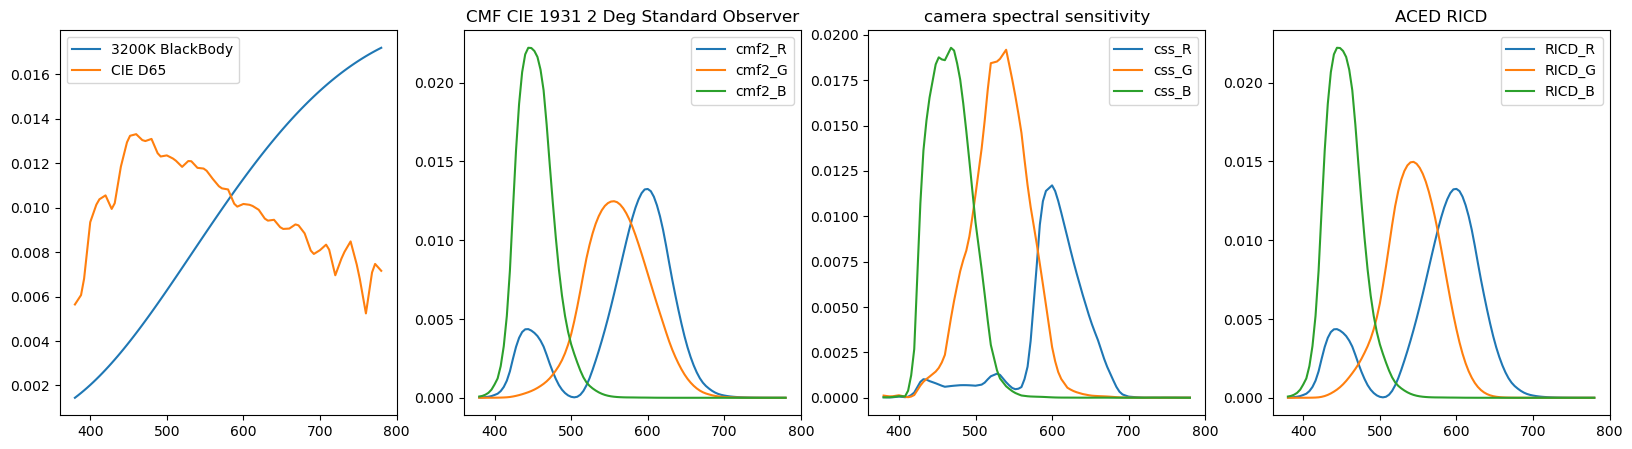

In [43]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.plot(wavelengths,spd_bd3200, label='3200K BlackBody')
plt.plot(wavelengths,spd_D65, label='CIE D65')
plt.legend()

plt.subplot(1,4,2)
plt.plot(wavelengths,np.transpose(arr_cmf2),
         label=['cmf2_R','cmf2_G','cmf2_B'])
plt.title('CMF CIE 1931 2 Deg Standard Observer')
plt.legend()

plt.subplot(1,4,3)
plt.plot(wavelengths,np.transpose(arr_css),
         label=['css_R','css_G','css_B'])
plt.title('camera spectral sensitivity')
# "The Flying Gray Ball Multi-illuminant Image Dataset for Color Research"
plt.legend()

plt.subplot(1,4,4)
plt.plot(wavelengths,np.transpose(arr_RICD),
         label=['RICD_R','RICD_G','RICD_B'])
plt.title('ACED RICD')
# Academy Color Encoding Specification Reference Image Capture Device
plt.legend()
plt.show()

$\sum = R_{in} + G_{in} + B_{in}$<br>
$p = \frac{R_{in}}{\sum}$<br>
$q = \frac{G_{in}}{\sum}$<br>

In [28]:
# calculate naive RGB values
RGB_naive = (arr_srd @ np.diag(spd_bd3200)) @ np.transpose(arr_css)
pq = RGB_naive[:,:2]/RGB_naive.sum(axis=1).reshape(-1,1)
sum_naive = RGB_naive.sum(axis=1).reshape(-1,1)


$\overline{R}_{LUT}(p_i,q_i) = R_{out}/\sum_{in}(p_i,q_i)$<br>
$\overline{G}_{LUT}(p_i,q_i) = G_{out}/\sum_{in}(p_i,q_i)$<br>
$\overline{B}_{LUT}(p_i,q_i) = B_{out}/\sum_{in}(p_i,q_i)$<br>

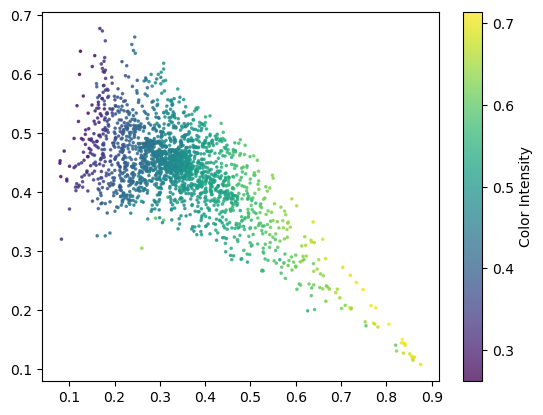

In [29]:
RGB_ACES = (arr_srd @ np.diag(spd_D65)) @ np.transpose(arr_RICD)
RGB_LUT = RGB_ACES/RGB_naive.sum(axis=1).reshape(-1,1)

plt.scatter(pq[:,0],pq[:,1],marker='.',c=RGB_LUT[:,0],cmap='viridis',s=10,alpha=0.75)
plt.colorbar(label='Color Intensity')
plt.show()

visualize the contour like Figure 6 (a) and (b) in "Camera Color Correction Using Two-Dimensional Transforms" (2013)

In [34]:
def generate_contour(x,y,z,label,cmap='viridis'):
    """figure (b) in Jon S. McElvain "Camera Color Correction Using Two-Dimensional Transform"
    """
    # Create a grid of points
    # x = pq[:,0]
    # y = pq[:,1]
    # z = RGB_LUT[:,0]
    grid_x, grid_y = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]

    # Interpolate the values to the grid
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

    # Create the convex hull
    hull = ConvexHull(np.column_stack((x, y)))
    hull_path = Path(np.column_stack((x[hull.vertices], y[hull.vertices])))

    # Create a mask for the grid points inside the convex hull
    mask = ~hull_path.contains_points(np.column_stack((grid_x.ravel(), grid_y.ravel())))
    mask = mask.reshape(grid_x.shape)

    # Apply the mask to the interpolated values
    grid_z[mask] = np.nan

    # plt.figure(figsize=(8, 6))
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap=cmap)
    plt.colorbar(contour, label=label)
    # plt.scatter(x, y, c='k', marker='.', alpha=0.5)  # Overlay the original points
    plt.xlabel('p')
    plt.ylabel('q')
    # plt.title('Contour Plot from Scatter Data with Convex Hull Mask')
    # plt.show()


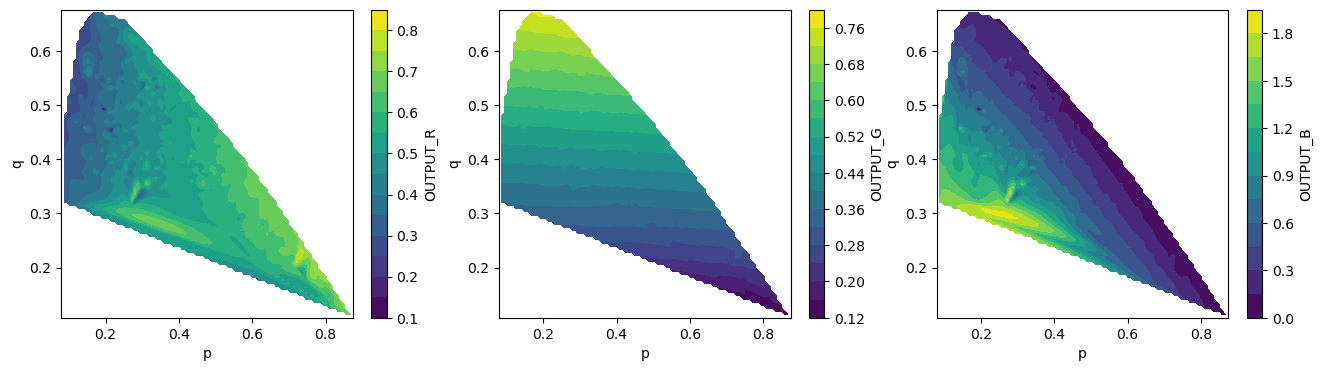

In [31]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
generate_contour(pq[:,0],pq[:,1],RGB_LUT[:,0],'OUTPUT_R')
plt.subplot(1,3,2)
generate_contour(pq[:,0],pq[:,1],RGB_LUT[:,1],'OUTPUT_G')
plt.subplot(1,3,3)
generate_contour(pq[:,0],pq[:,1],RGB_LUT[:,2],'OUTPUT_B')
plt.show()

using 3-by-3 color conversion matrix 

In [32]:
M = np.linalg.pinv(RGB_naive) @ RGB_ACES
RGB_ACES_hat = RGB_naive @ M
RGB_LUT_hat = RGB_ACES_hat/RGB_naive.sum(axis=1).reshape(-1,1)

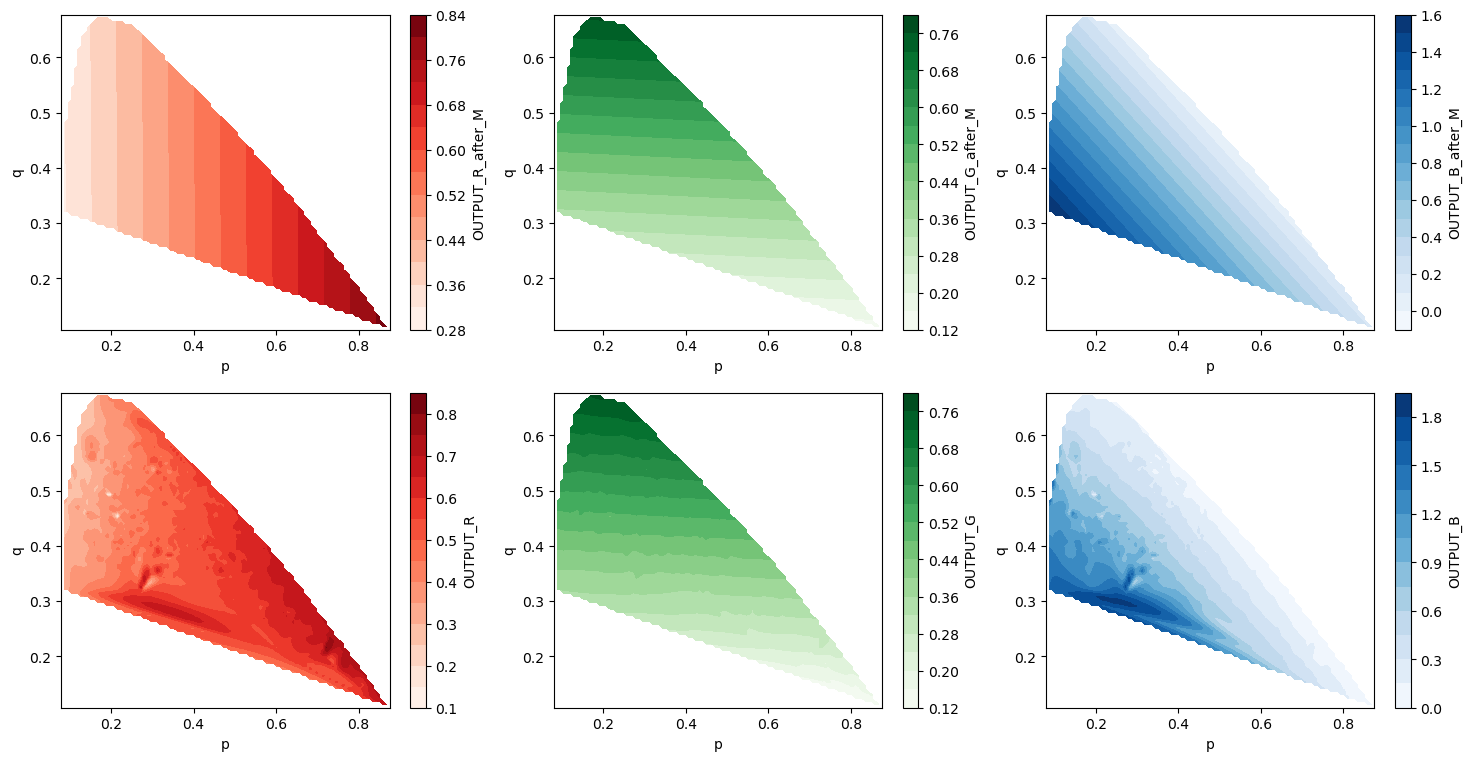

In [37]:
plt.figure(figsize=(18,9))
plt.subplot(2,3,1)
generate_contour(pq[:,0],pq[:,1],RGB_LUT_hat[:,0],'OUTPUT_R_after_M','Reds')
plt.subplot(2,3,2)
generate_contour(pq[:,0],pq[:,1],RGB_LUT_hat[:,1],'OUTPUT_G_after_M','Greens')
plt.subplot(2,3,3)
generate_contour(pq[:,0],pq[:,1],RGB_LUT_hat[:,2],'OUTPUT_B_after_M','Blues')
plt.subplot(2,3,4)
generate_contour(pq[:,0],pq[:,1],RGB_LUT[:,0],'OUTPUT_R','Reds')
plt.subplot(2,3,5)
generate_contour(pq[:,0],pq[:,1],RGB_LUT[:,1],'OUTPUT_G','Greens')
plt.subplot(2,3,6)
generate_contour(pq[:,0],pq[:,1],RGB_LUT[:,2],'OUTPUT_B','Blues')
plt.show()